# Electricity demand forecast in France


In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import math
from sklearn.decomposition import PCA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## General Description:


The electricity demand of France is very much dependent on weather data. The demand of France is an important driver of European electricity prices, as it is one of the biggest countries. France has a lot of interconnections with surrounding countries. Hence, in periods of high demand France is likely to import electricity from neighboring countries, which will result in higher prices in France and the other countries. In periods of low demand, France is likely to export, which will result in lower prices. That is the reason that market parties need a good insight and forecast of this demand in France.

## Problem Statement:
Please create a demand forecast for France on an hourly level up to 48 hours ahead, for the French Market. For example, if you create a forecast on 11 March at 00:00. You will forecast the demand until March 13th at 00:00

## Analysis
Please indicate, on a monthly basis, what the average demand is for a weekday or a weekend at a certain temperature. We are very interested to see what one degree colder in winter or one degree warmer in summer has, as an effect on demand.

## Data description

In [3]:
df = pd.read_csv("dataset.csv", sep=",")# Read data
df.head()

,Unnamed: 0,demand [MW],solar_actual [MW],solar_forecast [MW],solar_inferred_capacity [MW],wind_actual [MW],wind_inferred_capacity [MW],albedo [%],cloud_cover [%],frozen_precipitation [%],pressure [Pa],radiation [W/m2],air_tmp [Kelvin],ground_tmp [Kelvin],apparent_tmp [Kelvin],wind_direction [angle],wind_speed [m/s]
0,2017-01-01 00:00:00+01:00,76345.25,0.0,NaN,5756.44,597.50,10513.95,0.0,2.45,-3.80,102875.0,0.0,271.60,269.82,269.84,209.0,2.97
1,2017-01-01 01:00:00+01:00,75437.00,0.0,NaN,5756.44,597.50,10513.95,0.0,2.48,-3.46,102839.0,0.0,271.62,269.85,269.79,212.0,3.13
2,2017-01-01 02:00:00+01:00,73368.25,0.0,NaN,5756.44,635.25,10513.95,0.0,4.62,-5.48,102735.0,0.0,271.61,269.93,269.58,218.0,3.25
3,2017-01-01 03:00:00+01:00,72116.00,0.0,NaN,5756.44,628.50,10513.95,0.0,6.13,-6.91,102660.0,0.0,271.60,269.99,269.44,218.0,3.37
4,2017-01-01 04:00:00+01:00,68593.75,0.0,NaN,5756.44,608.50,10513.95,0.0,6.75,-7.50,102629.0,0.0,271.60,270.02,269.38,219.0,3.42


In [4]:
df.loc[0]

Unnamed: 0                      2017-01-01 00:00:00+01:00
demand [MW]                                      76345.25
solar_actual [MW]                                     0.0
solar_forecast [MW]                                   NaN
solar_inferred_capacity [MW]                      5756.44
wind_actual [MW]                                    597.5
wind_inferred_capacity [MW]                      10513.95
albedo [%]                                            0.0
cloud_cover [%]                                      2.45
frozen_precipitation [%]                             -3.8
pressure [Pa]                                    102875.0
radiation [W/m2]                                      0.0
air_tmp [Kelvin]                                    271.6
ground_tmp [Kelvin]                                269.82
apparent_tmp [Kelvin]                              269.84
wind_direction [angle]                              209.0
wind_speed [m/s]                                     2.97
Name: 0, dtype

In [5]:
df.head()
print(" Shape of the data: ", df.shape)

print(df.columns)

 Shape of the data:  (45432, 17)
Index(['Unnamed: 0', 'demand [MW]', 'solar_actual [MW]', 'solar_forecast [MW]',
       'solar_inferred_capacity [MW]', 'wind_actual [MW]',
       'wind_inferred_capacity [MW]', 'albedo [%]', 'cloud_cover [%]',
       'frozen_precipitation [%]', 'pressure [Pa]', 'radiation [W/m2]',
       'air_tmp [Kelvin]', 'ground_tmp [Kelvin]', 'apparent_tmp [Kelvin]',
       'wind_direction [angle]', 'wind_speed [m/s]'],
      dtype='object')


In [6]:
df['Time'] = pd.to_datetime(df['Unnamed: 0'])
df.index = df['Time']
df = df.drop(['Unnamed: 0'], 1)
df.head()

,demand [MW],solar_actual [MW],solar_forecast [MW],solar_inferred_capacity [MW],wind_actual [MW],wind_inferred_capacity [MW],albedo [%],cloud_cover [%],frozen_precipitation [%],pressure [Pa],radiation [W/m2],air_tmp [Kelvin],ground_tmp [Kelvin],apparent_tmp [Kelvin],wind_direction [angle],wind_speed [m/s],Time
Time,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,76345.25,0.0,NaN,5756.44,597.50,10513.95,0.0,2.45,-3.80,102875.0,0.0,271.60,269.82,269.84,209.0,2.97,2017-01-01 00:00:00+01:00
2017-01-01 01:00:00+01:00,75437.00,0.0,NaN,5756.44,597.50,10513.95,0.0,2.48,-3.46,102839.0,0.0,271.62,269.85,269.79,212.0,3.13,2017-01-01 01:00:00+01:00
2017-01-01 02:00:00+01:00,73368.25,0.0,NaN,5756.44,635.25,10513.95,0.0,4.62,-5.48,102735.0,0.0,271.61,269.93,269.58,218.0,3.25,2017-01-01 02:00:00+01:00
2017-01-01 03:00:00+01:00,72116.00,0.0,NaN,5756.44,628.50,10513.95,0.0,6.13,-6.91,102660.0,0.0,271.60,269.99,269.44,218.0,3.37,2017-01-01 03:00:00+01:00
2017-01-01 04:00:00+01:00,68593.75,0.0,NaN,5756.44,608.50,10513.95,0.0,6.75,-7.50,102629.0,0.0,271.60,270.02,269.38,219.0,3.42,2017-01-01 04:00:00+01:00



Here we are given with data from  01 January 2017 to 08 March 2022 that contains demand in MW(Mega Watts) for a particular Hour, Climate conditions at a particular hour. By the above we in total 45,432 hours of data with 17 columns in which we have Demand in MW, Solar and Wind Capacity in MW.

To state the climate conditions we have details like,

- Albedo in %
- cloud_cover [%]
- frozen_precipitation [%]
- pressure [Pa]
- radiation [W/m2]
- air_tmp [Kelvin]
- ground_tmp [Kelvin]
- apparent_tmp [Kelvin]
- wind_direction [angle]
- wind_speed [m/s]



## Exploratory Data Analysis

<AxesSubplot:xlabel='Time', ylabel='demand [MW]'>

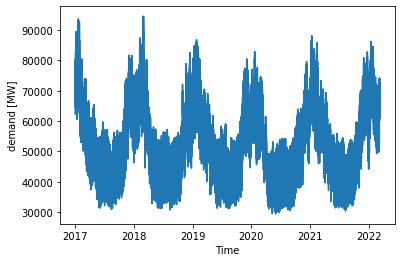

In [7]:
sns.lineplot(x= "Time", y="demand [MW]", data = df)

From the above given time series plot betwee 2017 to 2022 we can easily infer that the demand in electricity follows uniformity that is the electricity is very high during the start of the year and it gradually the demand comes down in mid year then it further increases. So from this in order to make analysis on monthly we can consider the data any year.

### Data cleaning

#### Missing values

In [8]:
df.isna().sum()

demand [MW]                       3
solar_actual [MW]                19
solar_forecast [MW]             222
solar_inferred_capacity [MW]      0
wind_actual [MW]                 19
wind_inferred_capacity [MW]       0
albedo [%]                       17
cloud_cover [%]                  16
frozen_precipitation [%]         10
pressure [Pa]                    11
radiation [W/m2]                 16
air_tmp [Kelvin]                 10
ground_tmp [Kelvin]              10
apparent_tmp [Kelvin]            10
wind_direction [angle]           11
wind_speed [m/s]                 11
Time                              0
dtype: int64

In [9]:
df.fillna(df['demand [MW]'].mode()[0], inplace = True)
df2 = df.drop(['solar_actual [MW]', "solar_forecast [MW]","wind_actual [MW]", "solar_inferred_capacity [MW]", "wind_inferred_capacity [MW]" ], 1).fillna(method='ffill')
#df.fillna(df['solar_forecast [MW]'])

In [10]:
df2.isna().sum()

demand [MW]                 0
albedo [%]                  0
cloud_cover [%]             0
frozen_precipitation [%]    0
pressure [Pa]               0
radiation [W/m2]            0
air_tmp [Kelvin]            0
ground_tmp [Kelvin]         0
apparent_tmp [Kelvin]       0
wind_direction [angle]      0
wind_speed [m/s]            0
Time                        0
dtype: int64

In [11]:
#df2.index = pd.to_datetime(df.index, utc = True)
months = []
years = []
for i in range(0, len(df2)):
    
    months.append(df2['Time'][i].strftime("%B"))
    years.append(df2['Time'][i].strftime("%Y"))

In [12]:
data = {'Months': months, 'Year': years, "Demand": df['demand [MW]']}

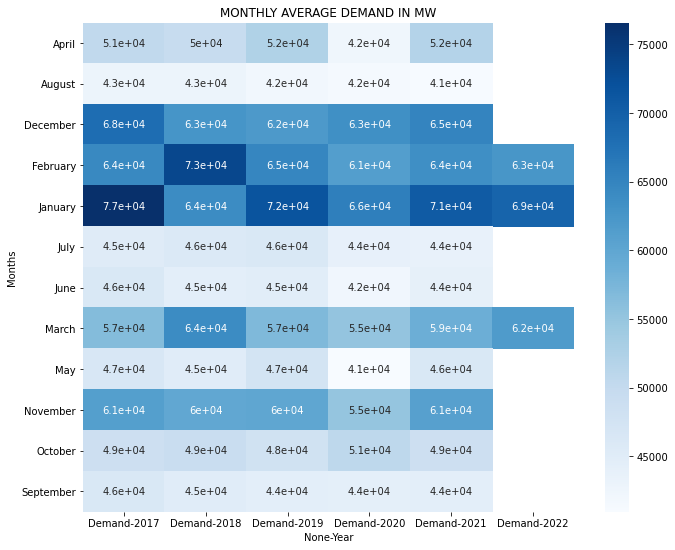

In [13]:
df1 = pd.DataFrame(data)
df_m= df1.groupby(['Year','Months']).mean().unstack(level=0)
fig, ax = plt.subplots(figsize=(11, 9))
title = 'monthly Average Demand in MW'.upper()
plt.title(title)
sns.heatmap(df_m, annot=True, cmap = 'Blues')
plt.show()

From this analysis we can infer that the higher electricity demands is during the months of January, February, March, November and December that is during the start of the year and end of the year. Furthermore we will analyze the electricity demand vs weather conditions to analyze this we are given with different climatic conditions. We utilize the correlation factor and additional statistical analysis to find the relation between the climatic conditions.

- Albedo in %
- cloud_cover [%]
- frozen_precipitation [%]
- pressure [Pa]
- radiation [W/m2]
- air_tmp [Kelvin]
- ground_tmp [Kelvin]
- apparent_tmp [Kelvin]
- wind_direction [angle]
- wind_speed [m/s]

In [14]:
c_data = {"albedo": df2['albedo [%]'], "Cloudcover": df2['cloud_cover [%]'], "frozenprec": df2["frozen_precipitation [%]"], "pressure":df2['pressure [Pa]'], "radiation": df2['radiation [W/m2]'], "air_tmp":df2['air_tmp [Kelvin]'], "gnd_tmp":df2['ground_tmp [Kelvin]'], "app_tmp":df2['apparent_tmp [Kelvin]'], "winddir":df2['wind_direction [angle]'], "windspeed":df2['wind_speed [m/s]']}
climate = pd.DataFrame(c_data)

<AxesSubplot:>

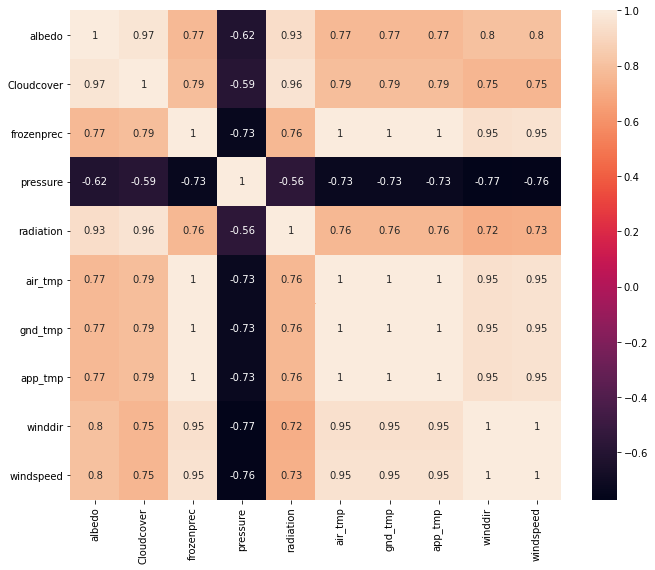

In [15]:
fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(climate.corr(), annot = True)

From the above analysis we can say that air temperature, Ground temperature and apparent temperature are highly correlated to each other additionally radition feature also have relatively good correlation with above. By considering this we can omit features such as Radiation, Air Temperature, Ground temperature and just keep Apparent temperature feature.

Now we make theoritical study to determine the remaining features.

- Apparent temperature is caluclated as AT  = f(pressure, humidity, wind speed, air temperature) that says we can omit wind speed and wind direction feature from the given data.

By all these analysis we can only consider apparent temperature because it can represent all other factors in the given data.

In [16]:
df1['apr_tmp'] = df2['apparent_tmp [Kelvin]']
df1['time'] = df2.index

In [17]:
def kelvinToCelsius(kelvin):
    return kelvin - 273.15
tmp = []
for i in df1['apr_tmp']:
    a = kelvinToCelsius(i)
    tmp.append(a)

In [18]:
df1['temp[C]'] = tmp

In [19]:
df2 = df1.drop(['Demand', 'apr_tmp', 'time'], 1)

In [20]:
df_c = df2.groupby(['Year','Months']).mean().unstack(level=0)

In [21]:
df_d= df1.groupby(['Months']).mean().unstack(level=0)


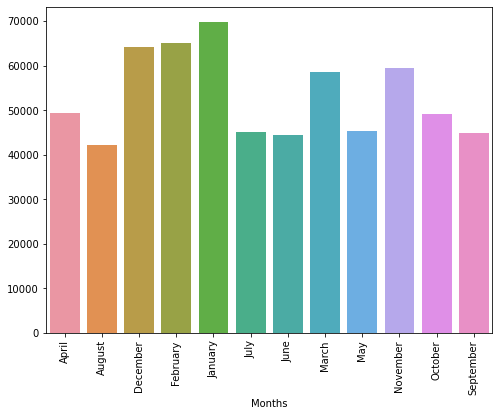

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.barplot(x=df_d['Demand'].index, y='Demand', data=df_d).set_xticklabels(ax.get_xticklabels(),rotation = 90)


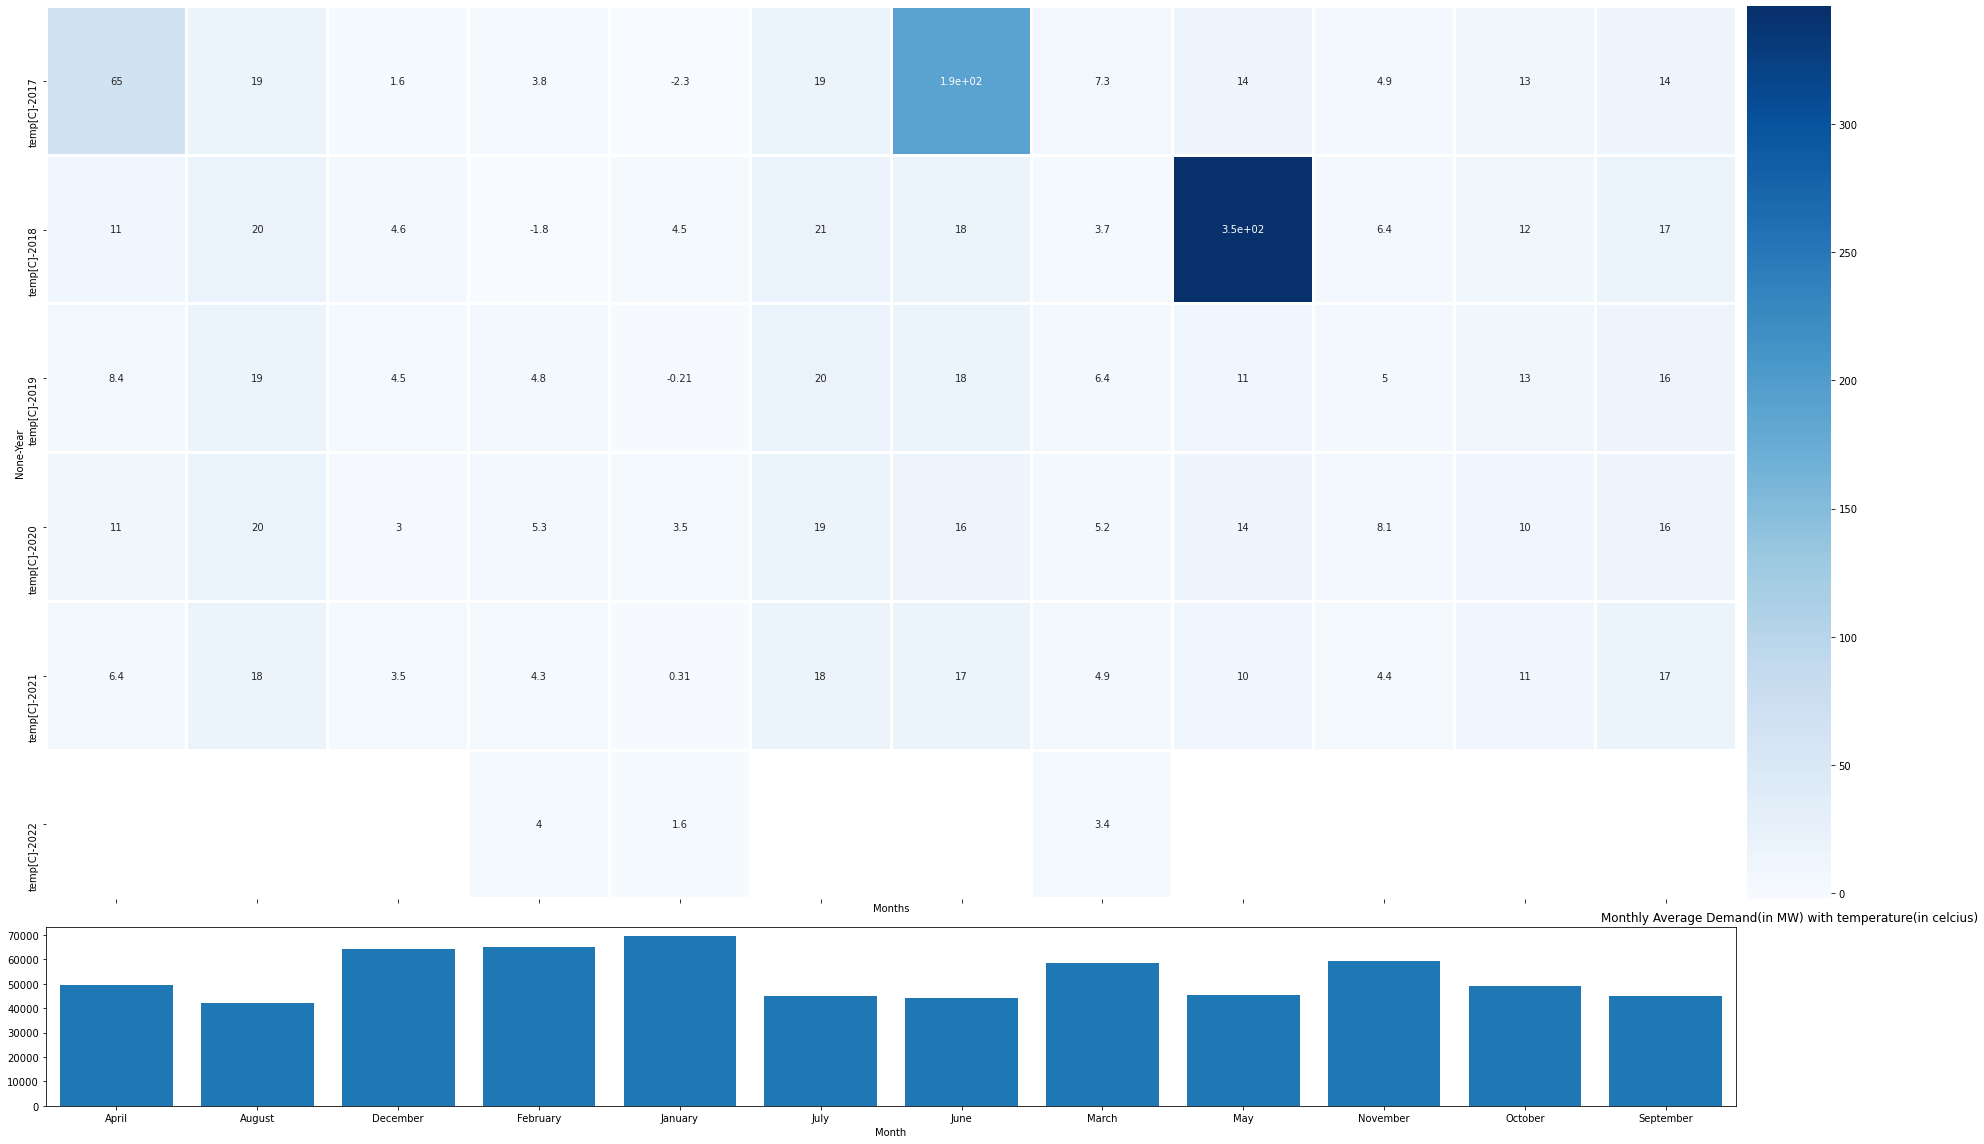

In [23]:
title = 'Monthly Average Demand(in MW) with temperature(in celcius)'

fig, ((ax1, cbar_ax), (ax2, dummy_ax)) = plt.subplots(nrows=2, ncols=2, figsize=(26, 16), sharex='col',
                                                      gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [20, 1]})
plt.title(title)

sns.heatmap(df_c.T, cmap="Blues", cbar_ax=cbar_ax, xticklabels=False, linewidths=2,annot = True, ax=ax1)
ax2.set_xlabel('Month')
x_ticks = df_c.index
x_tick_pos = [i + 0.5 for i in range(len(x_ticks))]
ax2.bar(x_tick_pos, list(df_d['Demand']), align='center')
sns.color_palette("husl", 9)

ax2.set_xticks(x_tick_pos)
ax2.set_xticklabels(x_ticks)
dummy_ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
X = df.drop(["demand [MW]", "Time"],1)
y = df["demand [MW]"]
X.shape

(45432, 15)

### Principle Component analysis

In [27]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])


In [28]:
principalDf.index = X.index

In [29]:
principalDf

,principal component 1,principal component 2
Time,,
2017-01-01 00:00:00+01:00,36751.229594,-1586.586485
2017-01-01 01:00:00+01:00,36751.534079,-1584.515812
2017-01-01 02:00:00+01:00,36748.477720,-1545.570122
2017-01-01 03:00:00+01:00,36749.697285,-1547.184175
2017-01-01 04:00:00+01:00,36751.995536,-1562.878174
...,...,...
2022-03-08 19:00:00+01:00,-1773.498591,1753.382688
2022-03-08 20:00:00+01:00,-1994.176187,2493.438381
2022-03-08 21:00:00+01:00,-2015.425332,2674.057138


In [30]:
tscv = TimeSeriesSplit(n_splits=5)
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
   

    return X_train, X_test, y_train, y_test

In [31]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(principalDf, y, 0.3)

In [32]:
X_train

,principal component 1,principal component 2
Time,,
2017-01-01 00:00:00+01:00,36751.229594,-1586.586485
2017-01-01 01:00:00+01:00,36751.534079,-1584.515812
2017-01-01 02:00:00+01:00,36748.477720,-1545.570122
2017-01-01 03:00:00+01:00,36749.697285,-1547.184175
2017-01-01 04:00:00+01:00,36751.995536,-1562.878174
...,...,...
2020-08-17 22:00:00+02:00,-1684.113096,-1258.285601
2020-08-17 23:00:00+02:00,-1680.596506,-1296.018645
2020-08-18 00:00:00+02:00,-1677.156224,-1323.539376


In [33]:
final = pd.DataFrame()
final['Time'] = df1["time"]
final['apr_tmp'] = df1['apr_tmp']
final['Demand'] = df1['Demand']

In [34]:
final.fillna(final['Demand'].mode()[0], inplace = True)

from the above graph we can easily see that during the months of January, February france experience colder days those can be termed as winter months from November to March during these months the electricity demand in France is relatively high where as in contrast June, July, August, September these are considered as Warm months in France proportionally demand is very low during these months.

From this analysis we can conclude that Electricity is very high during the months of winter and low in during other months that makes France export during those months.

## Prediction

To determine the forecast we have some techniques that helps us to bring out an accurate forecast of electricity demand.
- Moving average method

- Machine Learning Models 

- LSTM


### Baseline models


#### Weighted Moving Average method


In [35]:
def WA_Predictions(data):
    #print("we predict the values based on {} month".format(month))
    predicted_value=(data.values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,len(data)):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(data.values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(data.values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(data.values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    data['WA_Predicted'] = predicted_values
    data['WA_Error'] = error
    #mape_err = (sum(error)/len(error))/(sum(data.values)/len(data.values))
    mse_err = sum([e**2 for e in error])/len(error)
    return data['WA_Predicted']

#### Holt's Winter Triple exponential Forecasting method

In [36]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [37]:
Y  = list(df['demand [MW]'])

In [38]:
#X_train, X_test, y_train, y_test = timeseries_train_test_split(df['demand [MW]'], y, 0
Y_train =  Y[0:int(len(df['demand [MW]'])*0.7)]
Y_test = Y[int(len(df['demand [MW]'])*0.7)+1:]

In [43]:
wap = WA_Predictions(df['demand [MW]'])

In [44]:
alpha = 0.2
beta = 0.15
gamma = 0.2
season_len = 24
ad = list(df['demand [MW]'])
predict_values_3 =[]
predict_list_3 = []
tsne_flat_exp_avg_2 = []
yh_rep = triple_exponential_smoothing(ad[0:len(ad)], season_len, alpha, beta, gamma, 0)


In [45]:
y_true = list(df['demand [MW]'])

In [46]:
print("Weighted moving average  MEAN ABSOLUTE ERROR:",mean_absolute_error(y_true, wap))
#print("Weighted moving average -- MEAN SQUARED LOG ERROR:",mean_squared_log_error(y_true, wap))
print("Weighted moving average -- R-Square: ", r2_score(y_true, wap)*100)
print("Weighted moving average -- Mean Absolute Percentage error: ", mean_absolute_percentage_error(y_true, wap)*100)

Weighted moving average  MEAN ABSOLUTE ERROR: 2204.4765528702237
Weighted moving average -- R-Square:  94.81159942919965
Weighted moving average -- Mean Absolute Percentage error:  4.2406990689915345


In [47]:
print("Holt's Winter Forecast -- MEAN ABSOLUTE ERROR:", mean_absolute_error(y_true, yh_rep))
#print("Holt's Winter Forecast --  MEAN SQUARED LOG ERROR:", mean_squared_log_error(y_true, yh_rep))
print("Holt's Winter Forecast -- R-Square: ", r2_score(y_true, yh_rep)*100)
print("Holt's Winter Forecast -- MEAN ABSOLUTE PERCENTAGE ERROR: ", mean_absolute_percentage_error(y_true, yh_rep)*100)

Holt's Winter Forecast -- MEAN ABSOLUTE ERROR: 1039.7015527666856
Holt's Winter Forecast -- R-Square:  98.69570770381189
Holt's Winter Forecast -- MEAN ABSOLUTE PERCENTAGE ERROR:  2.0164032245320356


So now we develop machine learning model

### Machine learning models


In [48]:
def Linearreg(X_train, X_test, Y_train, Y_test):
     
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [ 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(X_train, Y_train)
    alpha = best_parameter.best_params_["alpha"]

    print(" Best Hyperparameter is : {}".format(alpha))
    
    print("."*100)
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(X_train, Y_train)
    train_pred = clf.predict(X_train)
    train_MAPE = mean_absolute_error(Y_train, train_pred)/ (sum(Y_train)/len(Y_train))
    train_MSE = mean_squared_error(Y_train, train_pred)
    
    test_pred = clf.predict(X_test)
    test_MAPE = mean_absolute_error(Y_test, test_pred)/(sum(Y_test)/len(Y_test))
    test_MSE = mean_squared_error(Y_test, test_pred)
    print("Test MAPE", test_MAPE)
    return [train_MAPE, train_MSE, test_MAPE, test_MSE]

In [60]:
def rfreg(X_train, Y_train, X_test, Y_test):
    #start = datetime.now()
    #hyper-paramater tuning
    values = [10, 30, 40, 80]
    regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3, n_jobs=-1)

    hyper_parameter = {"n_estimators": values}
    best_parameter = RandomizedSearchCV(regr1, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 2, n_jobs = -1)
    best_parameter.fit(X_train, Y_train)
    estimators = best_parameter.best_params_["n_estimators"]
    print("Best estimator : {}".format(estimators))
    #print('Time taken for tuning :', datetime.now() - start)
    print('.'*100)
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=estimators, n_jobs=-1)

    clf.fit(X_train, Y_train)
    train_pred = []
   
    train_pred.extend(clf.predict(X_train))
    train_MAPE = mean_absolute_error(Y_train, train_pred)/ (sum(Y_train)/len(Y_train))
    
    train_MSE = mean_squared_error(Y_train, train_pred)
    
    test_pred = []
    
    test_pred.extend(clf.predict(X_test))
    test_MAPE = mean_absolute_error(Y_test, test_pred)/(sum(Y_test)/len(Y_test))
    test_MSE = mean_squared_error(Y_test, test_pred)
    test_m = mean_absolute_percentage_error(Y_test, test_pred)*100
    print("Test MAPE", test_m)
    #print('Time taken :', datetime.now() - start)
    return [train_MAPE, train_MSE, test_MAPE, test_MSE]

In [61]:
def dtreg(X_train, Y_train, X_test, Y_test):
    #start = datetime.now()
    #hyper-paramater tuning
    values = [2, 3, 5, 7, 9]
    regr_1 = DecisionTreeRegressor(max_depth=values)
    hyper_parameter = {"max_depth": values}
    best_parameter = RandomizedSearchCV(regr_1, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 2, n_jobs = -1)
    best_parameter.fit(X_train, Y_train)
    estimators = best_parameter.best_params_["max_depth"]
    print("Best estimator : {}".format(estimators))
    #print('Time taken for tuning :', datetime.now() - start)
    print('.'*100)
    #applying random forest with best hyper-parameter
    clf = DecisionTreeRegressor(max_depth=estimators)
    clf.fit(X_train, Y_train)
    train_pred = []
   
    train_pred.extend(clf.predict(X_train))
    train_MAPE = mean_absolute_error(Y_train, train_pred)/ (sum(Y_train)/len(Y_train))
    
    train_MSE = mean_squared_error(Y_train, train_pred)
    
    test_pred = []
    
    test_pred.extend(clf.predict(X_test))
    test_MAPE = mean_absolute_error(Y_test, test_pred)/(sum(Y_test)/len(Y_test))
    test_MSE = mean_squared_error(Y_test, test_pred)
    test_m = mean_absolute_percentage_error(Y_test, test_pred)*100
    print("Test MAPE", test_m)
    #print('Time taken :', datetime.now() - start)
    return [train_MAPE, train_MSE, test_MAPE, test_MSE]

### Prepare Data for Machine learning models

In [51]:
fd = pd.DataFrame()
fd["cloudCover"] = df['cloud_cover [%]']
fd["app_temp"]  = df['apparent_tmp [Kelvin]']
fd["demand"] = df["demand [MW]"]
fd["tripleexpavg"] = yh_rep

In [52]:

for i in range(0, 5):
    #print(i+1)
    fd["lag_{}".format(i+1)] = fd['demand'].shift(i+1)
fd = fd.fillna(0)

In [53]:
scaler = StandardScaler()
X = fd.drop(['demand'], 1)
y = fd['demand']

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
#nwtrain = normalize(X_train)
#nwtest = normalize(X_test)
LRwmetric = Linearreg(X_train_scaled, X_test_scaled, y_train, y_test)

LRwtrainMAPE = LRwmetric[0]
LRwtrainMSE = LRwmetric[1]
LRwtestMAPE = LRwmetric[2]
LRwtestMSE = LRwmetric[3]

print("Train MAPE : {}".format(LRwtrainMAPE))
print("Train MSE : {}".format(LRwtrainMSE))
print("Test MAPE : {}".format(LRwtestMAPE))
print("Test MSE : {}".format(LRwtestMSE))

 Best Hyperparameter is : 1
....................................................................................................
Test MAPE 0.051285775719410835
Train MAPE : 0.05393064755366688
Train MSE : 13229922.910140684
Test MAPE : 0.051285775719410835
Test MSE : 12586671.696013033


In [55]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
test_pred = xgb.predict(X_test_scaled)

In [57]:
#test_pred.extend(clf.predict(X_test))
test_MAPE = mean_absolute_error(y_test, test_pred)/(sum(y_test)/len(y_test))

In [58]:
print("MEAN ABSOLUTE ERROR:",test_MAPE)


MEAN ABSOLUTE ERROR: 0.011768482494803287


In [62]:
dtwmetric =dtreg(X_train_scaled, y_train, X_test_scaled, y_test)
dtwtrainMAPE = dtwmetric[0]
dtwtrainMSE = dtwmetric[1]
dtwtestMAPE = dtwmetric[2]
dtwtestMSE = dtwmetric[3]

print("Train MAPE : {}".format(dtwtrainMAPE))
print("Train MSE : {}".format(dtwtrainMSE))
print("Test MAPE : {}".format(dtwtestMAPE))
print("Test MSE : {}".format(dtwtestMSE))

Best estimator : 9
....................................................................................................
Test MAPE 1.5672306663994786
Train MAPE : 0.01384740817468235
Train MSE : 949090.5677658604
Test MAPE : 0.015486808136789633
Test MSE : 1252150.4056916698


In [63]:
RFwmetric =rfreg(X_train_scaled, y_train, X_test_scaled, y_test)
RFwtrainMAPE = RFwmetric[0]
RFwtrainMSE = RFwmetric[1]
RFwtestMAPE = RFwmetric[2]
RFwtestMSE = RFwmetric[3]

print("Train MAPE : {}".format(RFwtrainMAPE))
print("Train MSE : {}".format(RFwtrainMSE))
print("Test MAPE : {}".format(RFwtestMAPE))
print("Test MSE : {}".format(RFwtestMSE))

Best estimator : 80
....................................................................................................
Test MAPE 1.12690333765672
Train MAPE : 0.007075243538844923
Train MSE : 286577.4847130103
Test MAPE : 0.011162894602148818
Test MSE : 659308.4067210872
